# Mounting to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
!pip install tensorflow

In [3]:
# !pip install fasttext

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Input, Flatten, MaxPooling1D, SpatialDropout1D, Activation

from keras.callbacks import EarlyStopping

from numpy import array
from sklearn.metrics import classification_report

import gensim
from gensim import models
from gensim.models import Word2Vec
# import fasttext.util
import pandas as pd
import numpy as np

# Loading Model

In [5]:
# fasttext_model = fasttext.load_model("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/notebooks/Tariq/fasttext/model_bn_300.bin")

# Load Dataset

In [6]:
train_dataset = pd.read_csv("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/dataset/task datasets/original/train.csv")
val_dataset = pd.read_csv("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/dataset/task datasets/original/dev.csv")
test_dataset = pd.read_csv("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/dataset/task datasets/original/test.csv")

In [7]:
print(f'train: {train_dataset.shape}\nval: {val_dataset.shape}\ntest: {test_dataset.shape}')

train: (2700, 2)
val: (1330, 2)
test: (2016, 2)


# Oversampling

In [8]:
train_dataset['label'].value_counts()

0    1389
1     922
2     389
Name: label, dtype: int64

In [9]:
# # Find the maximum class frequency
# max_class_frequency = train_dataset['label'].value_counts().max()

# # Group the dataset by labels
# grouped = train_dataset.groupby('label')

# resampled_data = []
# for label, group in grouped:
#     if len(group) < max_class_frequency:
#         oversampled_group = group.sample(max_class_frequency, replace=True, random_state=42)
#         resampled_data.append(oversampled_group)
#     else:
#         resampled_data.append(group)

# # Concatenate the resampled groups to create the balanced dataset
# balanced_dataset = pd.concat(resampled_data)

# # Shuffle the dataset to ensure randomness
# balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
# grouped.head()

In [11]:
# balanced_dataset.shape

In [12]:
# balanced_dataset['label'].value_counts()

In [13]:
# train_dataset = balanced_dataset
# train_dataset['label'].value_counts()

In [14]:
train_x = train_dataset['text']
train_y = train_dataset['label']

val_x = val_dataset['text']
val_y = val_dataset['label']

test_x = test_dataset['text']
test_y = test_dataset['label']

# Embedding Setup

In [15]:
tokenizer=Tokenizer(oov_token = "<OOV>", split=' ') # Splitting text based on whitespace and adding "Out of vocabulary"
tokenizer.fit_on_texts(train_x) # Using the tokenizer on out train dataset to tokenize the train dataset
train_encoded=tokenizer.texts_to_sequences(train_x)

In [16]:
train_padded= pad_sequences(train_encoded, padding='post', maxlen = 256)

In [17]:
train_padded.shape

(2700, 256)

In [18]:
# padding df_validation
val_encoded=tokenizer.texts_to_sequences(val_x)
val_padded= pad_sequences(val_encoded, padding='post', maxlen=train_padded.shape[1])

In [19]:
# padding df_validation
test_encoded=tokenizer.texts_to_sequences(test_x)
test_padded= pad_sequences(test_encoded, padding='post', maxlen=train_padded.shape[1])

In [20]:
# # function that takes word vector as input and returned an embedding layer
# def embedding_creation(EMBEDDING_DIM, word_vectors):
#   vocabulary_size=len(tokenizer.word_index)+1
#   word_index=tokenizer.word_index
#   embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

#   for word, i in word_index.items():
#     try:
#       embedding_vector=word_vectors[word] # taking the word vector of all the words in the index
#       embedding_matrix[i]=embedding_vector # inserting the vector of the word to the embeddings matrix,  index wise
#     except KeyError:
#       embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
#       """
#       The strategy of generating random vectors for missing words (KeyError)
#       in the embedding matrix is useful because it provides a way to
#       include out-of-vocabulary words in the representation,
#         prevents loss of information, helps with stable training, and
#         ensures a complete embedding matrix for neural network models.
#       """
#   embedding_layer=Embedding(vocabulary_size, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)

#   return embedding_layer

In [21]:
# EMBEDDING_DIM = 300
# wv = fasttext_model
# IFT = embedding_creation(EMBEDDING_DIM, wv)
# # gets the embedding layer from the word vectors using EMBEDDING_DIM as dim size

In [22]:
# max_length = train_padded.shape[1]
# vocabulary_size = len(tokenizer.word_index) + 1
# # creating a randomly initialized embedding layer (RE)
# RE = Embedding(vocabulary_size, EMBEDDING_DIM,input_length = max_length, trainable=True)

# Early Stopping

In [23]:
earlystop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

In [24]:
# emb_X_name_collection = [ [IFT, 'IFT']]

# Model Configuration Orignal

In [25]:
!pip install keras

In [26]:
from tensorflow.keras.layers import Layer, Embedding, Bidirectional, LSTM, GlobalMaxPool1D, Dense, GlobalAveragePooling1D, Lambda
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

In [27]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()


In [28]:
# num_classes = 3
# # Loop through each embedding layer and create models with attention
# for emb_X_name in emb_X_name_collection:
#     model = Sequential([
#         emb_X_name[0],
#         Bidirectional(LSTM(128, dropout=0.3, return_sequences=True)),
#         attention(),
#         Dense(16, activation='relu'),
#         Dense(num_classes, activation='softmax'),  # Use softmax for multi-class classification
#     ],
#     name="Sentiment_Model")
#     model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [29]:
# from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPool1D, Dense
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam

# num_classes = 3
# learning_rate = 0.001  # Adjust the learning rate as needed
# EMB_DIM = 300
# max_len = train_padded.shape[1]
# vocabulary_size=len(tokenizer.word_index)+1

In [30]:
# model = Sequential()
# model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300, input_length=max_len))
# model.add(LSTM(150, dropout=0.3, return_sequences=True))
# # model.add(attention()),
# model.add(GlobalMaxPool1D())
# model.add(Dense(16, activation='relu'))
# model.add(Dense(3, activation='softmax'))  # Assuming 3 classes (0, 1, 2)

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
!pip install gensim

In [32]:
from tensorflow.keras.optimizers import Adam
# Load the pre-trained CBOW Word2Vec model
from gensim.models import Word2Vec
window_size = 2  # Context window size
lstm_units = 150
dense_units = 32
num_classes = 3  # Assuming 3 classes (0, 1, 2)
learning_rate = 0.001  # Learni
cbow_model = Word2Vec.load("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/notebooks/Tariq/final/nafi/cbow_model")

# Get the word embeddings from the CBOW model
word_embeddings = cbow_model.wv
# Get the vocabulary size from the tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300  # Define your desired embedding dimension

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word_embeddings:
        embedding_matrix[i] = word_embeddings[word]

# Now, you have the embedding matrix with pre-trained word vectors

# Create a new model with the pre-trained embeddings
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=256, weights=[embedding_matrix], trainable=False))

# Add an LSTM layer with dropout and return sequences
model.add(Bidirectional(LSTM(units=lstm_units, dropout=0.3, return_sequences=True)))

# Define a Lambda layer to average the word embeddings within the context window
# model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(150,)))
model.add(GlobalMaxPool1D())
model.add(Dense(dense_units, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Add the learning rate to the Adam optimizer
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [33]:
# from tensorflow.keras.layers import Embedding, Lambda, Bidirectional, LSTM, Dense, Dropout
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# import tensorflow.keras.backend as K  # Import Keras backend for the Lambda layer
# import numpy as np

# # Assuming you have already tokenized and padded your text data
# # X_train_padded and y_train should contain the padded sequences and labels, respectively
# # You also need the tokenizer and vocab_size as defined in your original code

# # Hyperparameters
# vocab_size = len(tokenizer.word_index) + 1
# embedding_dim = 300
# window_size = 2  # Context window size
# lstm_units = 150
# dense_units = 32
# num_classes = 3  # Assuming 3 classes (0, 1, 2)
# learning_rate = 0.001  # Learning rate

# model = Sequential()
# model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# # Add a Bidirectional LSTM layer with dropout
# model.add(Bidirectional(LSTM(units=lstm_units, dropout=0.3, return_sequences=True)))

# # Define a Lambda layer to average the word embeddings within the context window
# model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(2*lstm_units,)))

# model.add(Dense(dense_units, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

# # Add the learning rate to the Adam optimizer
# optimizer = Adam(learning_rate=learning_rate)

# model.compile(optimizer=optimizer,
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# Training

In [34]:
history = model.fit(train_padded, train_y, epochs=100, batch_size=32, validation_data=(val_padded, val_y), callbacks=[earlystop_callback])

Epoch 1/100
85/85 [==============================] - 19s 60ms/step - loss: 1.0066 - accuracy: 0.5111 - val_loss: 0.9868 - val_accuracy: 0.5391
Epoch 2/100
85/85 [==============================] - 4s 53ms/step - loss: 0.9920 - accuracy: 0.5126 - val_loss: 0.9889 - val_accuracy: 0.5353
Epoch 3/100
85/85 [==============================] - 5s 55ms/step - loss: 0.9888 - accuracy: 0.5156 - val_loss: 0.9866 - val_accuracy: 0.5353
Epoch 4/100
85/85 [==============================] - 4s 41ms/step - loss: 0.9876 - accuracy: 0.5167 - val_loss: 0.9867 - val_accuracy: 0.5361
Epoch 5/100
85/85 [==============================] - 3s 31ms/step - loss: 0.9876 - accuracy: 0.5159 - val_loss: 0.9853 - val_accuracy: 0.5331
Epoch 6/100
85/85 [==============================] - 3s 31ms/step - loss: 0.9839 - accuracy: 0.5189 - val_loss: 0.9898 - val_accuracy: 0.5338
Epoch 7/100
85/85 [==============================] - 3s 30ms/step - loss: 0.9855 - accuracy: 0.5170 - val_loss: 0.9871 - val_accuracy: 0.5331
Epoch

In [35]:
# history = model.fit(train_padded, train_y, epochs=100, batch_size=32, validation_data=(test_padded, test_y), callbacks=[earlystop_callback])

In [36]:
# model.save("/content/drive/MyDrive/Research/final-model")  # Save the model in an h5 format

In [37]:
prediction = model.predict(test_padded)

p = []
for i in range(len(prediction)):
    a = []
    for j in range(3):
        a.append(round(prediction[i][j]))
    p.append(a)


63/63 [==============================] - 1s 11ms/step


In [38]:
# prediction

In [39]:
# Determine the maximum column index for each row
max_indices = np.argmax(p, axis=1)

# Create a DataFrame with the max_indices
pred_labels = pd.DataFrame({'Value': max_indices})

In [40]:
# pred_labels

In [41]:
from sklearn.metrics import classification_report

target_names = ['neutral', 'passive', 'active']
r = classification_report(test_y, pred_labels, output_dict=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
# r

In [43]:
df = pd.DataFrame(r)

# Transpose the DataFrame
df = df.transpose()

print(df)

              precision    recall  f1-score      support
0              0.544772  0.993613  0.703716  1096.000000
1              0.470588  0.011127  0.021739   719.000000
2              0.000000  0.000000  0.000000   201.000000
accuracy       0.544147  0.544147  0.544147     0.544147
macro avg      0.338454  0.334913  0.241818  2016.000000
weighted avg   0.464000  0.544147  0.390329  2016.000000


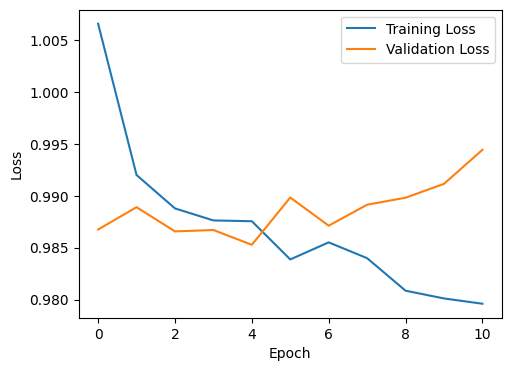

In [44]:
import matplotlib.pyplot as plt
# Plot the training history
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


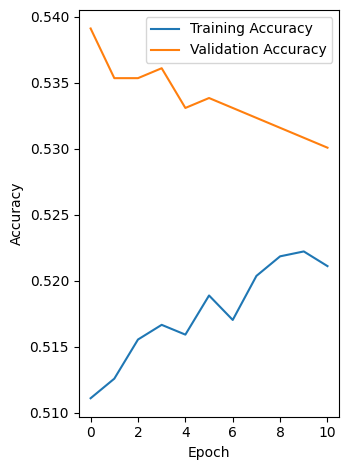

In [45]:
# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
# model.save("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/notebooks/Tariq/final/nafi/BiLSTMcbow.h5")  # Save the model in an h5 format

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
